In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_util import *

import pickle
import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 





In [2]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [3]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/cnn_kernel_check_dual/")
SAVE_DIR = os.path.join(CODE_DIR, "simple_cnn_models_dual/")

In [4]:

# Check if the directory exists
if not os.path.exists(FIG_DIR):
    # Create the directory
    os.makedirs(FIG_DIR)
    print(f"Directory '{FIG_DIR}' was created.")
else:
    print(f"Directory '{FIG_DIR}' already exists.")



if not os.path.exists(SAVE_DIR):
    # Create the directory
    os.makedirs(SAVE_DIR)
    print(f"Directory '{SAVE_DIR}' was created.")
else:
    print(f"Directory '{SAVE_DIR}' already exists.")

Directory '/home/jenny/evidence-chain/figs/cnn_kernel_check_dual/' already exists.
Directory '/home/jenny/evidence-chain/simple_cnn_models_dual/' already exists.


In [5]:
stimdur = '250'
pos = 8
evaluate_mode = False

In [6]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_116221/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_116221/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_116221/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [7]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [8]:
df.shape

(3400, 13)

In [9]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [10]:
count.max()

29

In [11]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [12]:
# fig, ax = plot_performance_matrix(performance_matrix_test)

In [13]:
dataset, dataset_resp = make_dataset(pos, count, chain_matrix)
x_train_val, x_test, y_train_val, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.3, random_state=2024
)
x_train, x_val, y_train, y_val = train_test_split(
x_train_val, y_train_val, test_size=0.25, random_state=1
)

In [14]:
print(len(x_train), len(x_val), len(x_test))

672 225 385


In [15]:
# x_train = get_evidence(x_train)
# x_val = get_evidence(x_val)
# x_test = get_evidence(x_test)

In [19]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create datasets
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)
test_dataset = create_dataset(x_test, y_test)
train_val_dataset = create_dataset(x_train_val, y_train_val)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_val_loader= DataLoader(train_val_dataset, batch_size=batch_size)



x_train.shape

In [20]:

# Define the model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=4, stride=1, padding=0)  # output is N x 16 x 5
        self.fc1 = nn.Linear(2, 1,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        # x = torch.relu(x)
        x, max_ind= torch.max(x[:,:,-2:], 2)  # Global average pooling
        # print(max_ind)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [21]:

if evaluate_mode:
    PATH = f'/home/jenny/evidence-chain/simple_cnn_models_dual/best_pos{pos}_running,pkl'
    model =CNN1D()
    model.load_state_dict(torch.load(PATH))
    model.eval()
    model = model.to(device)


    # Loss function and optimizer
    criterion = nn.BCELoss()


    # Train the model
    num_epochs = 20
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss,_,_ = evaluate(model, train_loader, criterion, device)
        val_loss, _, _ = evaluate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # if epoch % 10 ==0:
        #     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # Evaluate AUC on the test set
    test_loss, test_outputs, test_targets = evaluate(model, test_loader, criterion,device)
    train_loss, train_outputs, train_targets = evaluate(model, train_loader, criterion,device)

    test_auc = roc_auc_score(test_targets, test_outputs)
    train_auc = roc_auc_score(train_targets, train_outputs)


    print(f'Train Loss: {train_loss}')
    print(f'Train AUC: {train_auc}')



    test_auc = roc_auc_score(test_targets, test_outputs)
    print(f'Test Loss: {test_loss}')
    print(f'Test AUC: {test_auc}')



===================ATTEMP 0======================
Train Loss: 0.39613212716011775
Train AUC: 0.608251122726938
Test Loss: 0.3104794460993547
Test AUC: 0.5934593023255814
saved a better model!


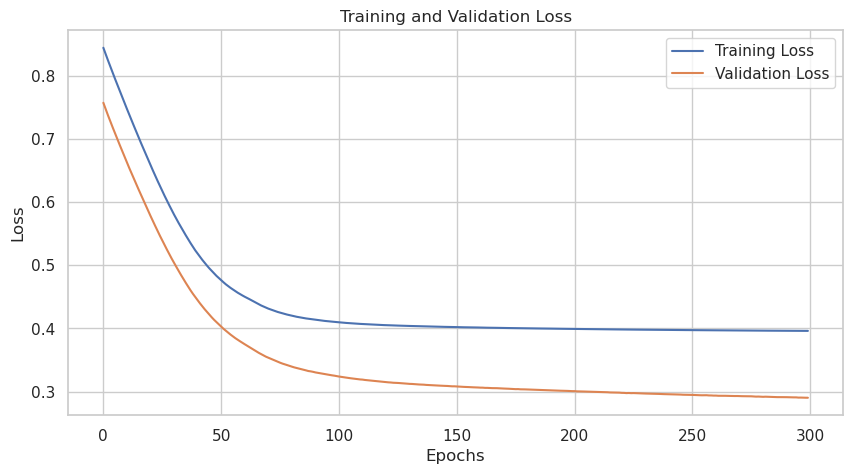

Epoch 1, Train Loss: 0.3670046421988257
Epoch 11, Train Loss: 0.3649781438811072
Epoch 21, Train Loss: 0.36386351595664845
Epoch 31, Train Loss: 0.3632339326472118
Epoch 41, Train Loss: 0.362825575573691
Epoch 51, Train Loss: 0.36255766451358795
Epoch 61, Train Loss: 0.36238456594532936
Epoch 71, Train Loss: 0.36227448490159264
Epoch 81, Train Loss: 0.362205378454307
Epoch 91, Train Loss: 0.36216236137110613
Epoch 101, Train Loss: 0.36213574430038187
Epoch 111, Train Loss: 0.36211932990057716
Epoch 121, Train Loss: 0.3621092161227917
Epoch 131, Train Loss: 0.3621029843544138
Epoch 141, Train Loss: 0.36209915064532183
Epoch 151, Train Loss: 0.362096781360692
Epoch 161, Train Loss: 0.36209531128406525
Epoch 171, Train Loss: 0.36209440488239814
Epoch 181, Train Loss: 0.3620938401797722
Epoch 191, Train Loss: 0.3620934856349024
Epoch 201, Train Loss: 0.3620932549238205
Epoch 211, Train Loss: 0.3620931156750383
Epoch 221, Train Loss: 0.36209301856057396
Epoch 231, Train Loss: 0.362092964094

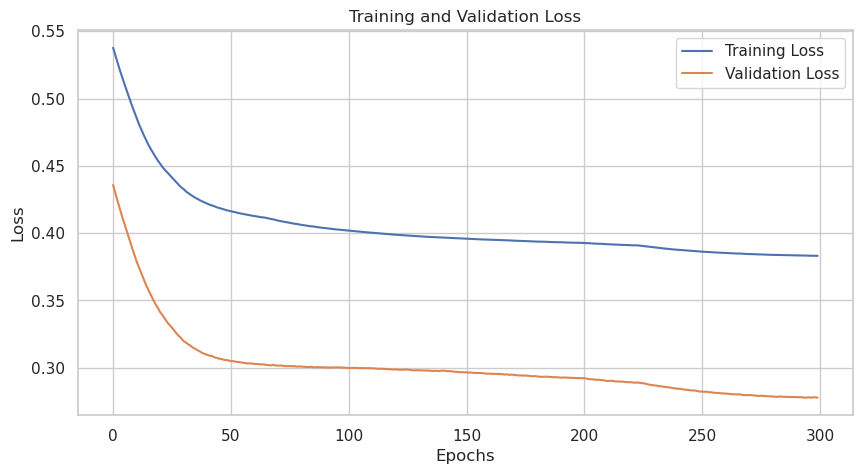

Epoch 1, Train Loss: 0.3540365105045253
Epoch 11, Train Loss: 0.35227086677633485
Epoch 21, Train Loss: 0.3514877064474698
Epoch 31, Train Loss: 0.3510660657594944
Epoch 41, Train Loss: 0.35077621299644995
Epoch 51, Train Loss: 0.350555096720827
Epoch 61, Train Loss: 0.3503755233411131
Epoch 71, Train Loss: 0.3502237195598668
Epoch 81, Train Loss: 0.35009218752384186
Epoch 91, Train Loss: 0.34997657917696856
Epoch 101, Train Loss: 0.3498732581220824
Epoch 111, Train Loss: 0.3497871617818701
Epoch 121, Train Loss: 0.34970909408454237
Epoch 131, Train Loss: 0.34964156202201185
Epoch 141, Train Loss: 0.3495784761576817
Epoch 151, Train Loss: 0.3495254763241472
Epoch 161, Train Loss: 0.3494753488178911
Epoch 171, Train Loss: 0.3494342077395012
Epoch 181, Train Loss: 0.34939605203168145
Epoch 191, Train Loss: 0.3493591742268924
Epoch 201, Train Loss: 0.34932416163641833
Epoch 211, Train Loss: 0.3493032830542532
Epoch 221, Train Loss: 0.3492799570848202
Epoch 231, Train Loss: 0.3492579264887

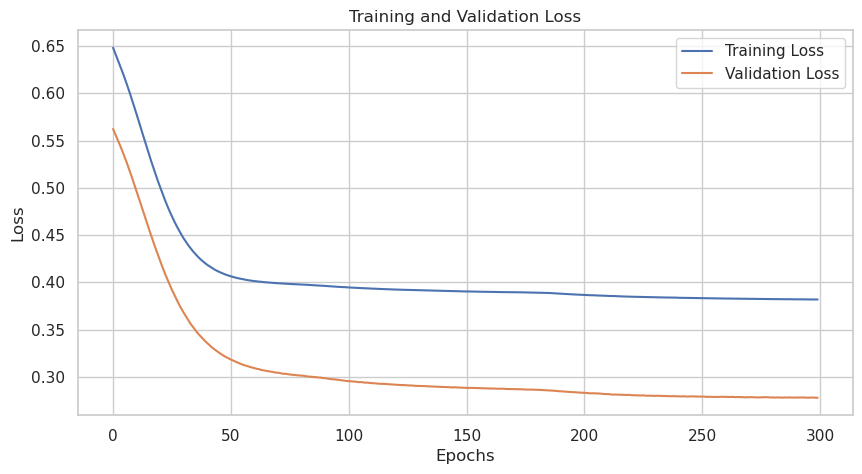

Epoch 1, Train Loss: 0.35320010370221633
Epoch 11, Train Loss: 0.3516788148674472
Epoch 21, Train Loss: 0.3509750582020858
Epoch 31, Train Loss: 0.35055292577579106
Epoch 41, Train Loss: 0.3502657973560794
Epoch 51, Train Loss: 0.35005665442039224
Epoch 61, Train Loss: 0.34989792673752224
Epoch 71, Train Loss: 0.34977421781112406
Epoch 81, Train Loss: 0.3496759194752266
Epoch 91, Train Loss: 0.3495965692503699
Epoch 101, Train Loss: 0.3495316597922095
Epoch 111, Train Loss: 0.3494779323709422
Epoch 121, Train Loss: 0.34943297659528666
Epoch 131, Train Loss: 0.349395005867399
Epoch 141, Train Loss: 0.3493626343792883
Epoch 151, Train Loss: 0.3493348262433348
Epoch 161, Train Loss: 0.34931101470158016
Epoch 171, Train Loss: 0.349292886154405
Epoch 181, Train Loss: 0.34927467693542613
Epoch 191, Train Loss: 0.34925872293011895
Epoch 201, Train Loss: 0.34924219702852183
Epoch 211, Train Loss: 0.34922933270191325
Epoch 221, Train Loss: 0.3492165207862854
Epoch 231, Train Loss: 0.34920452021

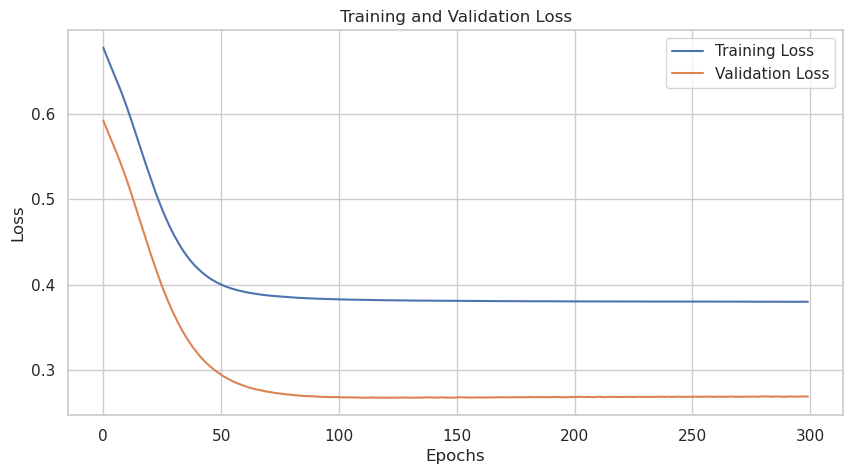

Epoch 1, Train Loss: 0.3491072253934268
Epoch 11, Train Loss: 0.3481271878398698
Epoch 21, Train Loss: 0.3479217568348194
Epoch 31, Train Loss: 0.34783053038449124
Epoch 41, Train Loss: 0.34776877483417246
Epoch 51, Train Loss: 0.34772077048646993
Epoch 61, Train Loss: 0.3476811570340189
Epoch 71, Train Loss: 0.3476472830977933
Epoch 81, Train Loss: 0.34761763646684846
Epoch 91, Train Loss: 0.34759129635218916
Epoch 101, Train Loss: 0.3475676327943802
Epoch 111, Train Loss: 0.3475462218810772
Epoch 121, Train Loss: 0.3475267522293946
Epoch 131, Train Loss: 0.3475089438002685
Epoch 141, Train Loss: 0.34749261315526636
Epoch 151, Train Loss: 0.34747757993895434
Epoch 161, Train Loss: 0.34746371158238115
Epoch 171, Train Loss: 0.3474508698644309
Epoch 181, Train Loss: 0.34743896023980503
Epoch 191, Train Loss: 0.34742788713553857
Epoch 201, Train Loss: 0.3474175827256564
Epoch 211, Train Loss: 0.3474079555478589
Epoch 221, Train Loss: 0.3473989660369939
Epoch 231, Train Loss: 0.3473905535

In [23]:
num_attempts = 300

if not evaluate_mode:
    best_test_auc = 0
    best_train_auc = 0
    num_epochs = 300
    num_epochs_final = 400
    
    for i in range(num_attempts):
        
        model_1 = CNN1D().to(device)
        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = Adam(model_1.parameters(), lr=0.0005)


        # Train the model
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_epoch(model_1, train_loader, criterion, optimizer, device)
            val_loss, _, _ = evaluate(model_1, val_loader, criterion, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # if epoch % 10 ==0:
            #     print(f'Epoch {epoch+1}, Train Loss: {}, Validation Loss: {val_loss}')



        # Evaluate AUC on the test set
        test_loss, test_outputs, test_targets = evaluate(model_1, test_loader, criterion, device)
        train_loss, train_outputs, train_targets = evaluate(model_1, train_loader, criterion, device)

        test_auc = roc_auc_score(test_targets, test_outputs)
        train_auc = roc_auc_score(train_targets, train_outputs)

        print(f"===================ATTEMP {i}======================")

        print(f'Train Loss: {train_loss}')
        print(f'Train AUC: {train_auc}')



        test_auc = roc_auc_score(test_targets, test_outputs)
        print(f'Test Loss: {test_loss}')
        print(f'Test AUC: {test_auc}')

        if test_auc >best_test_auc and train_auc>best_train_auc:
            best_test_auc = test_auc
            best_train_auc = train_auc
            PATH = f'/home/jenny/evidence-chain/simple_cnn_models_dual/best_pos{pos}_running.pkl'
            torch.save(model_1.state_dict(), PATH)
            print("saved a better model!")

                # # Plot training and validation losses
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()


            conv_bias = model_1.conv1.bias.data
            weights = model_1.conv1.weight.data
            fc_weights = model_1.fc1.weight.data

            kernel = weights.cpu().numpy()
            fc_bias = fc_weights.cpu().numpy()
            conv_bias = conv_bias.cpu().numpy()
            mydict = {}
            mykeys = ["kernel", "position","fc_bias", "conv_bias"]
            values = [kernel, pos, fc_bias, conv_bias]
            for key, value in zip(mykeys, values):
                   mydict[key] = value
            
            FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_running.pkl")
            with open(FILEPATH, 'wb') as pickle_file:
                pickle.dump(mydict, pickle_file)

            ## continue training)
    
            train_val_losses = []

            for epoch in range(num_epochs_final):
                train_val_loss = train_epoch(model_1, train_val_loader, criterion, optimizer, device)
                train_val_losses.append(train_val_loss)
                if epoch % 10 ==0:
                    print(f'Epoch {epoch+1}, Train Loss: {train_val_loss}')



            # Evaluate AUC on the test set
            test_loss_final, test_outputs_final, test_targets_final = evaluate(model_1, test_loader, criterion, device)
            train_loss_final, train_outputs_final, train_targets_final = evaluate(model_1, train_val_loader, criterion, device)

            test_auc_final = roc_auc_score(test_targets_final, test_outputs_final)
            train_auc_final = roc_auc_score(train_targets_final, train_outputs_final)

            print(f"===================ATTEMP {i} final training======================")

            print(f'Train Loss: {train_loss_final}')
            print(f'Train AUC: {train_auc_final}')

            print(f'Test Loss: {test_loss_final}')
            print(f'Test AUC: {test_auc_final}')


            if test_auc_final >best_test_auc and train_auc_final>best_train_auc:
                best_test_auc = test_auc_final
                best_train_auc = train_auc_final
                PATH = f'/home/jenny/evidence-chain/simple_cnn_models_dual/best_pos{pos}_continued.pkl'
                torch.save(model_1.state_dict(), PATH)
                print("saved a better final model!")

                    # # Plot training and validation losses
                plt.figure(figsize=(10, 5))
                plt.plot(train_val_losses, label='Training Loss Final')
                plt.title('Final Training Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

                conv_bias = model_1.conv1.bias.data
                weights = model_1.conv1.weight.data
                fc_weights = model_1.fc1.weight.data

                kernel = weights.cpu().numpy()
                fc_bias = fc_weights.cpu().numpy()
                conv_bias = conv_bias.cpu().numpy()
                mydict = {}
                mykeys = ["kernel", "position","fc_bias", "conv_bias"]
                values = [kernel, pos, fc_bias, conv_bias]
                for key, value in zip(mykeys, values):
                    # Here you can add conditions or transformations
                    mydict[key] = value
                # Save the dictionary into a pickle file
                
                FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_continued.pkl")
                with open(FILEPATH, 'wb') as pickle_file:
                    pickle.dump(mydict, pickle_file)




In [ ]:
num_attempts = 300


if not evaluate_mode:
    best_test_auc = 0
    best_train_auc = 0
    num_epochs_final = 400
    
    for i in range(num_attempts):
        
        model_2 = CNN1D().to(device)
        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = Adam(model_2.parameters(), lr=0.0005)



        train_val_losses = []

        for epoch in range(num_epochs_final):
            train_val_loss = train_epoch(model_2, train_val_loader, criterion, optimizer, device)
            train_val_losses.append(train_val_loss)


        # Evaluate AUC on the test set
        test_loss_final, test_outputs_final, test_targets_final = evaluate(model_2, test_loader, criterion, device)
        train_loss_final, train_outputs_final, train_targets_final = evaluate(model_2, train_val_loader, criterion, device)

        test_auc_final = roc_auc_score(test_targets_final, test_outputs_final)
        train_auc_final = roc_auc_score(train_targets_final, train_outputs_final)

        print(f"===================ATTEMP {i} final training======================")

        print(f'Train Loss: {train_loss_final}')
        print(f'Train AUC: {train_auc_final}')

        print(f'Test Loss: {test_loss_final}')
        print(f'Test AUC: {test_auc_final}')


        if test_auc_final >best_test_auc and train_auc_final>best_train_auc:
            best_test_auc = test_auc_final
            best_train_auc = train_auc_final
            PATH = f'/home/jenny/evidence-chain/simple_cnn_models_dual/best_pos{pos}_final.pkl'
            torch.save(model_2.state_dict(), PATH)
            print("saved a better final model!")

                # # Plot training and validation losses
            plt.figure(figsize=(10, 5))
            plt.plot(train_val_losses, label='Training Loss Final')
            plt.title('Final Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            conv_bias = model_2.conv1.bias.data
            weights = model_2.conv1.weight.data
            fc_weights = model_2.fc1.weight.data

            kernel = weights.cpu().numpy()
            fc_bias = fc_weights.cpu().numpy()
            conv_bias = conv_bias.cpu().numpy()
            mydict = {}
            mykeys = ["kernel", "position","fc_bias", "conv_bias"]
            values = [kernel, pos, fc_bias, conv_bias]
            for key, value in zip(mykeys, values):
                # Here you can add conditions or transformations
                mydict[key] = value
            # Save the dictionary into a pickle file
            
            FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_final.pkl")
            with open(FILEPATH, 'wb') as pickle_file:
                pickle.dump(mydict, pickle_file)


In [ ]:
model.fc1.weight.data

In [ ]:
conv_bias = model.conv1.bias.data

In [ ]:
conv_bias

In [ ]:
weights = model.conv1.weight.data

In [ ]:
weights

In [ ]:
fc_weights = model.fc1.weight.data

In [ ]:
fc_weights

In [ ]:
for w in weights:
    w = w.cpu().numpy().squeeze()
    print(w)
    plt.plot(np.arange(0,4),w,'o-')
    plt.show()

In [ ]:
# weights_list = []


In [ ]:
m = nn.Conv1d(1, 1, 3, stride=2,bias=False)


In [ ]:
input = torch.tensor([1,2,3],dtype=torch.float32).reshape(1,3)

In [ ]:
m.weight.data

In [ ]:
output = m(input)

In [ ]:
output

In [ ]:
m.weight.data @ input.T

In [ ]:
a = np.array((0.4437, -0.3275, -0.3687))
b = np.array((1,2,3))